Building permits provide a valuable source of information on construction and housing development in San Francisco. I'd like to look at the permits to identify properties and modalities that are most suitable for additional attention in addressing our housing shortage

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt

# handles geodata
import geopandas as gp
# converts coordinate pairs into points that can be interpreted by geopandas
from shapely.geometry import Point
# map plotting
import geoplot as gplt
import geoplot.crs as gcrs
# geoplot is based on cartopy
import cartopy
import cartopy.crs as ccrs

In [3]:
# Convert the location information for geopandas
def parse_point(record):
    try:
        pieces = record.split() # splits each record into a list of 3
        x = float(pieces[0].lstrip('(').rstrip(',')) # latitude
        y = float(pieces[1].rstrip(')')) # longitude 
        point = Point(x,y) # convert to Shapely Point
    except:
        print(record)
    return point



In [4]:
df = pd.read_csv('Building_Permits.csv')
df['PID'] = df['Location'].dropna().map(lambda x: parse_point(x))
df.columns

Index(['Permit Number', 'Permit Type', 'Permit Type Definition',
       'Permit Creation Date', 'Block', 'Lot', 'Street Number',
       'Street Number Suffix', 'Street Name', 'Street Suffix', 'Unit',
       'Unit Suffix', 'Description', 'Current Status', 'Current Status Date',
       'Filed Date', 'Issued Date', 'Completed Date',
       'First Construction Document Date', 'Structural Notification',
       'Number of Existing Stories', 'Number of Proposed Stories',
       'Voluntary Soft-Story Retrofit', 'Fire Only Permit',
       'Permit Expiration Date', 'Estimated Cost', 'Revised Cost',
       'Existing Use', 'Existing Units', 'Proposed Use', 'Proposed Units',
       'Plansets', 'TIDF Compliance', 'Existing Construction Type',
       'Existing Construction Type Description', 'Proposed Construction Type',
       'Proposed Construction Type Description', 'Site Permit',
       'Supervisor District', 'Neighborhoods - Analysis Boundaries', 'Zipcode',
       'Location', 'Record ID', 'SF Fi

In [5]:
df.head()

,Permit Number,Permit Type,Permit Type Definition,Permit Creation Date,Block,Lot,Street Number,Street Number Suffix,Street Name,Street Suffix,...,SF Find Neighborhoods,Current Police Districts,Current Supervisor Districts,Analysis Neighborhoods,DELETE - Zip Codes,DELETE - Fire Prevention Districts,DELETE - Supervisor Districts,DELETE - Current Police Districts,DELETE - Supervisorial_Districts_Waterline_data_from_7pkg_wer3,PID
0,M276234,8,otc alterations permit,08/25/2011,0293,001,211,NaN,Sutter,St,...,19.0,6.0,3.0,8.0,28857.0,5.0,10.0,1.0,2.0,POINT (37.78963350193874 -122.4040524493755)
1,M244529,8,otc alterations permit,03/02/2011,3647,011,1170,NaN,Guerrero,St,...,52.0,3.0,5.0,20.0,28859.0,2.0,5.0,7.0,1.0,POINT (37.75240296788822 -122.4233061753566)
2,200505021369,8,otc alterations permit,05/02/2005,5956,014,154,NaN,Edinburg,St,...,90.0,9.0,1.0,7.0,28861.0,9.0,6.0,4.0,8.0,POINT (37.7267095810297 -122.428213181891)
3,201111179152,8,otc alterations permit,11/17/2011,3744,002,345,NaN,Spear,St,...,30.0,1.0,10.0,8.0,28855.0,6.0,9.0,2.0,3.0,POINT (37.7898032532225 -122.3897574541635)
4,M360647,8,otc alterations permit,12/03/2012,6506,034,4159,NaN,24th,St,...,84.0,3.0,5.0,22.0,28862.0,2.0,5.0,7.0,1.0,POINT (37.75097504978157 -122.4353578287229)


Text(0.5, 1.0, 'Breakdown of Permit Types')

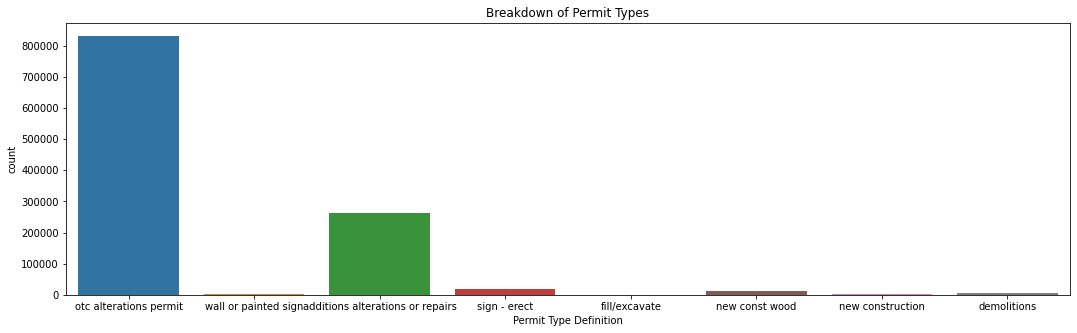

In [47]:
df['Permit Type Definition'].replace('grade or quarry or fill or excavate','fill/excavate', inplace=True)
df['Permit Type Definition'].replace('new construction wood frame','new const wood', inplace=True)
plt.figure(figsize=(18,5))
sns.countplot(df['Permit Type Definition'])
plt.title('Breakdown of Permit Types')

Text(0.5, 1.0, 'Revised Cost')

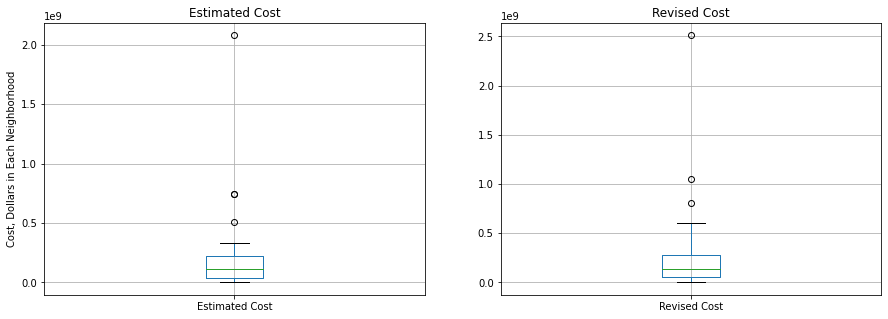

In [76]:
nb_df = df.groupby('Permit Type Definition').get_group('additions alterations or repairs').loc[:,['Current Status','Number of Existing Stories','Number of Proposed Stories','Existing Units','Proposed Units','Estimated Cost', 'Revised Cost','Neighborhoods - Analysis Boundaries','PID']]
nb_df = nb_df.dropna().groupby(['Current Status']).get_group(('complete'))
nb_sums = nb_df.groupby(['Neighborhoods - Analysis Boundaries']).sum()


# Compare proposed to existing units to see how many have been added
nb_sums['Units Added Pct'] = 100 * (nb_sums['Proposed Units'] - nb_sums['Existing Units'])/nb_sums['Existing Units']
nb_sums.head()

plt.figure(figsize=(15,5))

plt.subplot(1,2,1)
plt.ylabel('Cost, Dollars in Each Neighborhood')
nb_sums['Estimated Cost'].to_frame().boxplot()
plt.title('Estimated Cost')

plt.subplot(1,2,2)
nb_sums['Revised Cost'].to_frame().boxplot()
plt.title('Revised Cost')


Verify that the Record ID is unique for each entry

Not completed


In [11]:
dates_df = df.loc[:, 'Filed Date':'Issued Date'].dropna().apply(pd.to_datetime)
dates_df['Approval Time'] = dates_df['Issued Date'] - dates_df['Filed Date']
dates_df['Approval Time'] = dates_df['Approval Time'].apply(lambda x: x.days)


In [48]:
dates_df

,Filed Date,Issued Date,Approval Time
52,2018-06-07,2018-06-07,0
89,2018-02-06,2018-02-06,0
158,2019-06-07,2019-06-13,6
179,2018-02-16,2019-05-17,455
263,2018-10-18,2018-10-19,1
...,...,...,...
1137687,2004-11-24,2004-11-24,0
1137688,2004-11-24,2005-06-06,194
1137689,2004-11-24,2004-11-24,0
1137690,2020-03-26,2020-03-26,0


In [15]:
# There are a few thousand entries with extremely long wait times (>2 years) for approval.
long_wait = dates_df['Approval Time'][(dates_df['Approval Time']>=700)]
len(long_wait)

6899

In [16]:
dates_df['Approval Time'].max()
# find and drop wait times with negative values
# find and examine wait times >10000 days (see how many there are?)

29608

In [17]:
df['Current Status']

0             filed
1             filed
2             filed
3             filed
4             filed
             ...   
1137687      issued
1137688      issued
1137689    complete
1137690      issued
1137691     expired
Name: Current Status, Length: 1137692, dtype: object

In [6]:
len(df['Record ID'].value_counts()) == len(df.index)

True

In [7]:
df['Current Status'].value_counts()

complete       620026
issued         230482
expired        225790
cancelled       26690
filed           21279
withdrawn        7894
approved         1610
reinstated       1292
filing           1196
disapproved       584
suspend           472
revoked           232
plancheck          60
appeal             28
issuing            23
denied             10
inspection          5
incomplete          3
unknown             2
granted             1
upheld              1
Name: Current Status, dtype: int64

In [8]:
df['Permit Type Definition'].value_counts()

otc alterations permit                 831365
additions alterations or repairs       261640
sign - erect                            18382
new construction wood frame             12647
demolitions                              6846
wall or painted sign                     3763
new construction                         2267
grade or quarry or fill or excavate       782
Name: Permit Type Definition, dtype: int64

In [9]:
df['Proposed Units'].value_counts()

1.0       302544
0.0       249749
2.0       135991
3.0        56315
4.0        32830
           ...  
1850.0         1
1785.0         1
686.0          1
1741.0         1
510.0          1
Name: Proposed Units, Length: 624, dtype: int64

In [10]:
df['Permit Creation Date']

0          08/25/2011
1          03/02/2011
2          05/02/2005
3          11/17/2011
4          12/03/2012
              ...    
1137687    11/24/2004
1137688    11/24/2004
1137689    11/24/2004
1137690    03/26/2020
1137691    01/26/1998
Name: Permit Creation Date, Length: 1137692, dtype: object

Next, we'll check the expansion of housing per neighborhood by using the existing units of each permit application and calculating the percent increase in unit to find which neighborhoods have the most growth. We'll use the 'completed' 'additions...' type permits, as these are the permits proposing, and completing additional units in each neighborhood.

In [53]:
nb_df = df.groupby('Permit Type Definition').get_group('additions alterations or repairs').loc[:,['Current Status','Number of Existing Stories','Number of Proposed Stories','Existing Units','Proposed Units','Estimated Cost', 'Revised Cost','Neighborhoods - Analysis Boundaries','PID']]
nb_df = nb_df.dropna().groupby(['Current Status']).get_group(('complete'))


,Number of Existing Stories,Number of Proposed Stories,Existing Units,Proposed Units,Estimated Cost,Revised Cost
Neighborhoods - Analysis Boundaries,,,,,,
Bayview Hunters Point,4778.0,4842.0,15427.0,15617.0,7.445952e+08,8.100151e+08
Bernal Heights,2864.0,2945.0,3374.0,3398.0,2.981798e+08,3.127235e+08
Castro/Upper Market,4783.0,4939.0,5394.0,5467.0,1.746140e+08,2.124365e+08
Chinatown,19100.0,19118.0,34050.0,22193.0,2.804494e+08,3.275728e+08
Excelsior,1562.0,2157.0,1159.0,1294.0,3.564529e+07,5.151664e+07


,Number of Existing Stories,Number of Proposed Stories,Existing Units,Proposed Units,Estimated Cost,Revised Cost,Units Added Pct
Neighborhoods - Analysis Boundaries,,,,,,,
Bayview Hunters Point,4778.0,4842.0,15427.0,15617.0,7.445952e+08,8.100151e+08,1.231607
Bernal Heights,2864.0,2945.0,3374.0,3398.0,2.981798e+08,3.127235e+08,0.711322
Castro/Upper Market,4783.0,4939.0,5394.0,5467.0,1.746140e+08,2.124365e+08,1.353356
Chinatown,19100.0,19118.0,34050.0,22193.0,2.804494e+08,3.275728e+08,-34.822320
Excelsior,1562.0,2157.0,1159.0,1294.0,3.564529e+07,5.151664e+07,11.647972


In [33]:
#read in a shapefile
sfneigh = gp.read_file('sf_n.dbf')
sfneigh.set_index('nhood', inplace=True)


In [21]:
# Convert the neighborhood information to geopandas
nbgeo = gp.GeoDataFrame(nb_df, geometry='PID')
nbgeo = nbgeo[nbgeo.PID.type == 'Point']
nbgeo


,Current Status,Number of Existing Stories,Number of Proposed Stories,Existing Units,Proposed Units,Estimated Cost,Revised Cost,Neighborhoods - Analysis Boundaries,PID,Units Added Pct
1680,complete,6.0,6.0,0.0,0.0,3800000.0,3800000.0,Financial District/South Beach,POINT (37.787 -122.403),NaN
4056,complete,5.0,5.0,1.0,1.0,15000.0,15000.0,Noe Valley,POINT (37.744 -122.435),0.0
4069,complete,9.0,9.0,0.0,0.0,10000.0,10000.0,Financial District/South Beach,POINT (37.789 -122.403),NaN
4079,complete,3.0,3.0,1.0,1.0,4890.0,25000.0,Bayview Hunters Point,POINT (37.730 -122.372),0.0
4122,complete,2.0,2.0,1.0,1.0,80000.0,80000.0,Inner Sunset,POINT (37.756 -122.471),0.0
...,...,...,...,...,...,...,...,...,...,...
1137657,complete,33.0,33.0,0.0,0.0,100000.0,100000.0,Financial District/South Beach,POINT (37.792 -122.398),NaN
1137666,complete,20.0,20.0,0.0,0.0,30000.0,34782.0,Chinatown,POINT (37.795 -122.404),NaN
1137674,complete,20.0,20.0,0.0,0.0,41000.0,85000.0,Chinatown,POINT (37.795 -122.404),NaN
1137684,complete,2.0,2.0,2.0,2.0,2000.0,2000.0,Lone Mountain/USF,POINT (37.775 -122.443),0.0


In [34]:
ax = gplt.polyplot(sfneigh.geometry, projection = gcrs.LambertConformal(), figsize=(12,8), edgecolor="k")

Error in callback <function install_repl_displayhook.<locals>.post_execute at 0x000000000B044840> (for post_execute):


TypeError: cannot create weak reference to 'NoneType' object

TypeError: cannot create weak reference to 'NoneType' object

<Figure size 864x576 with 1 Axes>

In [ ]:
ax = gplt.choropleth)

In [ ]:
nbgeo

Possible cases, ranked, but work bottom to top!: 
1. generate map view of permit acceptance times for one of the figures 
2. plot of distribution of wait time for approval by estimated cost or property value (https://medium.com/the-era-of-apis/how-to-use-the-zillow-api-with-python-to-get-real-estate-insights-f37f72041713)
3. Regular analysis of neighborhoods using groupby, get group, counts, etc
4. munge/clean the data for variables of interest as needed
5. spend 20 minutes writing up rationale, and conducting background research

Predict the approval/disapproval time of a permit, **work completion time** and other factors given:
appraisal value, types of work being done, and other factors
work completion time from permit approval: correlated with some other categories? 
Use: can be used by contractors to evaluate which jobs are worth doing or for example, by homeowner/loanbroker to evaluate the reliability of a project

What other data can be brought in:
appraisal value of the home
costs for different types of jobs/sqft of home